In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import kagglehub


In [2]:
# Movie dataset from KaggleHub
path = kagglehub.dataset_download("adrianmcmahon/imdb-india-movies")
print(" Dataset downloaded at:", path)

 Dataset downloaded at: C:\Users\Admin\.cache\kagglehub\datasets\adrianmcmahon\imdb-india-movies\versions\1


In [3]:
print(os.listdir(path))

['IMDb Movies India.csv']


In [4]:
# Load the dataset
file_path = os.path.join(path, "IMDb Movies India.csv")
df = pd.read_csv(file_path, encoding='latin1')
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
# Structure of dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [6]:
# Count missing values
df.isnull().sum()


Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [7]:
# Drop rows with missing Rating
df.dropna(subset=['Rating'], inplace=True)

# Fill remaining missing values with "Unknown"
df.fillna("Unknown", inplace=True)


In [8]:
# Keep only selected features for prediction
df = df[['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Rating']]

# Rename columns for simplicity
df.columns = ['Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Rating']
df.head()

,Genre,Director,Star1,Star2,Star3,Rating
1,Drama,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7.0
3,"Comedy, Romance",Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4.4
5,"Comedy, Drama, Musical",Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,4.7
6,"Drama, Romance, War",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7.4
8,"Horror, Mystery, Thriller",Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,5.6


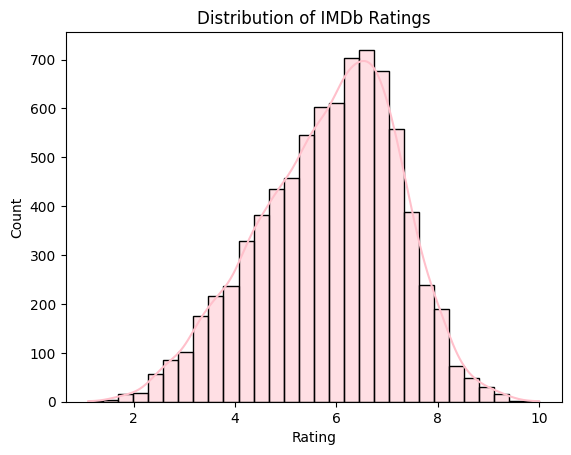

In [9]:
sns.histplot(data=df, x='Rating', kde=True, bins=30, color='pink')
plt.title("Distribution of IMDb Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10572\3244944206.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df.head(10), x='Count', y='Genre', palette='magma', ax=axs[0, 0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_10572\3244944206.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_rating.head(10), x='Rating', y='Genre', palette='coolwarm', ax=axs[0, 1])


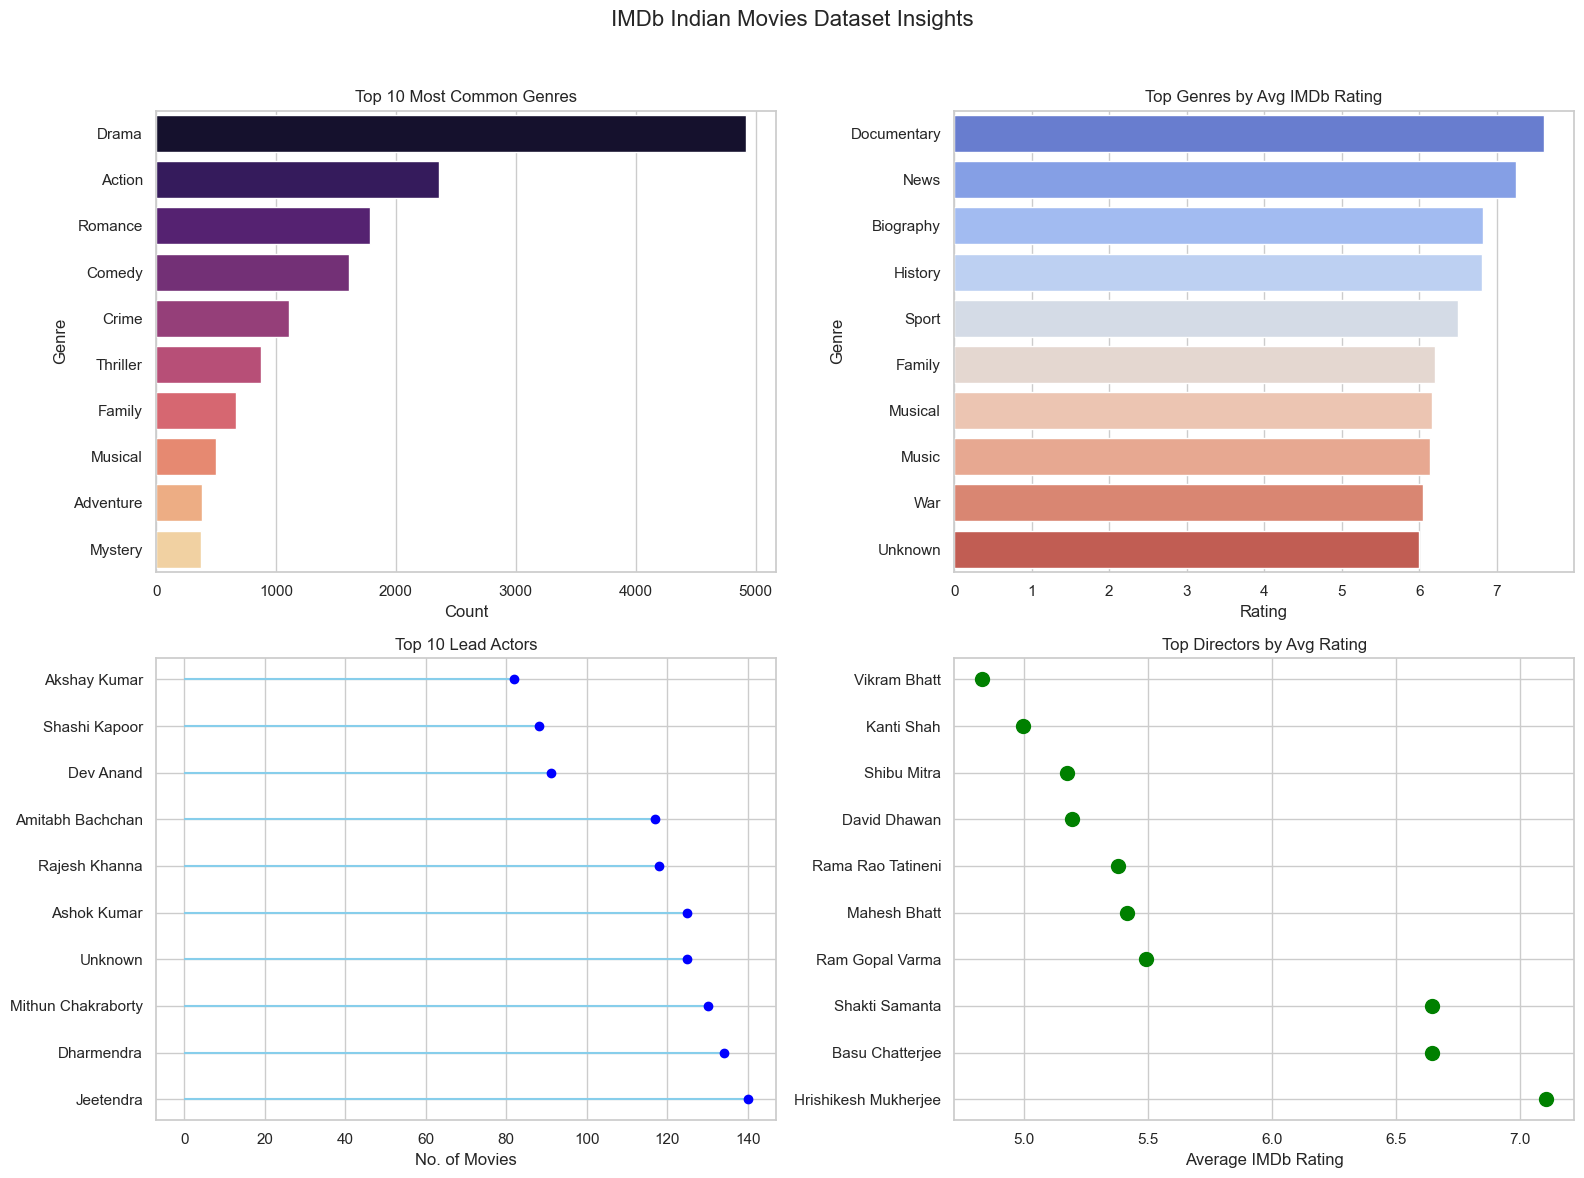

In [10]:
# Plot styling
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("IMDb Indian Movies Dataset Insights", fontsize=16)

# Chart 1: Top 10 Most Common Genres 
genre_list = df['Genre'].dropna().apply(lambda x: x.split(', '))
all_genres = [g for sublist in genre_list for g in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

sns.barplot(data=genre_df.head(10), x='Count', y='Genre', palette='magma', ax=axs[0, 0])
axs[0, 0].set_title("Top 10 Most Common Genres")

# Chart 2: Average IMDb Rating by Genre 
df_genre = df.copy()
df_genre['Genre'] = df_genre['Genre'].str.split(', ')
df_genre = df_genre.explode('Genre')
avg_rating = df_genre.groupby('Genre')['Rating'].mean().sort_values(ascending=False).reset_index()

sns.barplot(data=avg_rating.head(10), x='Rating', y='Genre', palette='coolwarm', ax=axs[0, 1])
axs[0, 1].set_title("Top Genres by Avg IMDb Rating")

# Chart 3: Top 10 Lead Actors
actors = df['Star1'].value_counts().nlargest(10)
axs[1, 0].hlines(y=actors.index, xmin=0, xmax=actors.values, color='skyblue')
axs[1, 0].plot(actors.values, actors.index, "o", color='blue')
axs[1, 0].set_title("Top 10 Lead Actors")
axs[1, 0].set_xlabel("No. of Movies")

# Chart 4: Top Directors by Average Rating
top_dirs = df['Director'].value_counts().nlargest(10).index
dir_rating = df[df['Director'].isin(top_dirs)].groupby('Director')['Rating'].mean().sort_values(ascending=False)

axs[1, 1].scatter(dir_rating.values, dir_rating.index, color='green', s=100)
axs[1, 1].set_title("Top Directors by Avg Rating")
axs[1, 1].set_xlabel("Average IMDb Rating")

#  layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:
#One-hot encode categorical features
cat_df = df[['Genre', 'Director', 'Star1', 'Star2', 'Star3']]
encoded = pd.get_dummies(cat_df, drop_first=True)

final_df = pd.concat([encoded, df['Rating']], axis=1)

In [12]:
# Features & Target
X = final_df.drop('Rating', axis=1)
y = final_df['Rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [13]:
# predictions
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" Mean Squared Error:", mse)
print(" R² Score:", r2)


 Mean Squared Error: 8.138837571444517
 R² Score: -3.3777311375655517


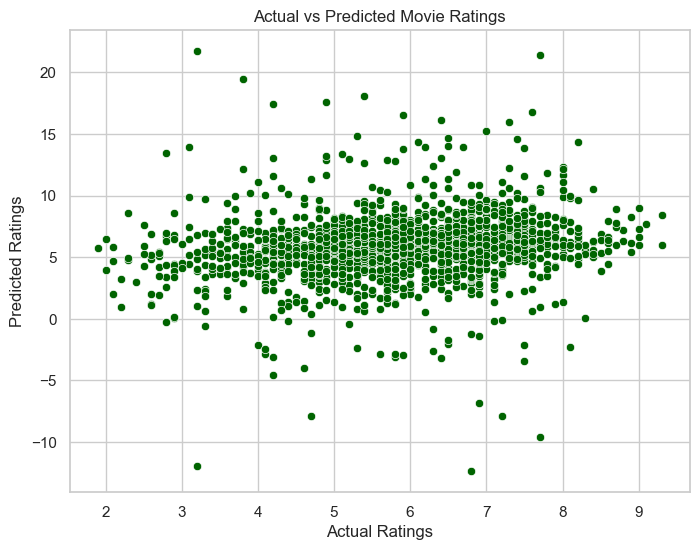

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='darkgreen')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Movie Ratings")
plt.grid(True)
plt.show()
